<a href="https://colab.research.google.com/github/nickdhollman/MS-BAnDS-Google-Colab/blob/BAN-5743-Predictive-Analytics/Association_Rule_Mining_Ex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORT DATA

In [2]:
from google.colab import files

uploaded = files.upload()

Saving transactions.sas7bdat to transactions.sas7bdat


IMPORT LIBRARIES

In [1]:
# Importing libraries
!pip install sidetable
!pip install mlxtend
!pip install pyreadstat
import numpy as np
import pandas as pd
import pyreadstat
import sidetable
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 22.6 MB/s eta 0:00:00


In [3]:
# Loading the data
file_path = 'transactions.sas7bdat'
df, meta = pyreadstat.read_sas7bdat(file_path)

DATA EXPLORATION

In [4]:
#initial data exploration
print(df.head())
print(df.shape)
print(df.dtypes)

   Quantity  Transaction  Store        Product
0       1.0      12359.0    2.0      Candy Bar
1       2.0      12362.0    9.0  Pain Reliever
2       2.0      12362.0    9.0  Pain Reliever
3       1.0      12365.0    5.0     Toothpaste
4       2.0      12371.0    2.0            Bow
(459258, 4)
Quantity       float64
Transaction    float64
Store          float64
Product         object
dtype: object


In [5]:
# any na values
print(df.isna().sum())

Quantity       0
Transaction    0
Store          0
Product        0
dtype: int64


In [8]:
df.stb.freq(['Store'])

,Store,count,percent,cumulative_count,cumulative_percent
0,7.0,46570,10.140270,46570,10.140270
1,3.0,46381,10.099116,92951,20.239386
2,6.0,46299,10.081262,139250,30.320648
3,2.0,46100,10.037931,185350,40.358578
4,5.0,46032,10.023124,231382,50.381703
5,8.0,45993,10.014632,277375,60.396335
6,1.0,45896,9.993511,323271,70.389846
7,10.0,45516,9.910769,368787,80.300615
8,4.0,45354,9.875495,414141,90.176110
9,9.0,45117,9.823890,459258,100.000000


In [6]:
df.stb.freq(['Product'])

,Product,count,percent,cumulative_count,cumulative_percent
0,Magazine,73951,16.102278,73951,16.102278
1,Toothpaste,63805,13.893062,137756,29.995340
2,Candy Bar,62375,13.581690,200131,43.577031
3,Greeting Cards,40292,8.773282,240423,52.350313
4,Pencils,38123,8.300999,278546,60.651311
5,Pens,36032,7.845699,314578,68.497010
6,Perfume,25142,5.474483,339720,73.971493
7,Bow,24554,5.346450,364274,79.317943
8,Wrapping Paper,17227,3.751051,381501,83.068994
9,Photo Processing,16386,3.567929,397887,86.636923


In [10]:
df['Quantity'].describe()

,Quantity
count,459258.000000
mean,2.823086
std,11.709258
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2325.000000


In [7]:
#drop store & quantity as both of these are rejected in the analysis
df_ = df.drop(['Store', 'Quantity'], axis=1)
print(df_.head())

   Transaction        Product
0      12359.0      Candy Bar
1      12362.0  Pain Reliever
2      12362.0  Pain Reliever
3      12365.0     Toothpaste
4      12371.0            Bow


In [11]:
# how many unique transactions are there?
print(df_['Transaction'].nunique())

200000


CREATE OBJECT TO BE USED IN ASSOCIATION RULE ANALYSIS

In [12]:
# create crosstabulation to have transaction as the row and unique products as the column
df2 = pd.crosstab(df_['Transaction'], df_['Product'])
print(df2.head())

Product      Bow  Candy Bar  Deodorant  Greeting Cards  Magazine  Markers  \
Transaction                                                                 
12359.0        0          1          0               0         0        0   
12362.0        0          0          0               0         0        0   
12365.0        0          0          0               0         0        0   
12371.0        1          0          0               0         0        0   
12380.0        0          0          0               1         0        0   

Product      Pain Reliever  Pencils  Pens  Perfume  Photo Processing  \
Transaction                                                            
12359.0                  0        0     0        0                 0   
12362.0                  2        0     0        0                 0   
12365.0                  0        0     0        0                 0   
12371.0                  0        0     0        0                 0   
12380.0                  0  

In [13]:
print(df2.shape)
print(df2.columns)

(200000, 17)
Index(['Bow', 'Candy Bar', 'Deodorant', 'Greeting Cards', 'Magazine',
       'Markers', 'Pain Reliever', 'Pencils', 'Pens', 'Perfume',
       'Photo Processing', 'Prescription Med', 'Shampoo', 'Soap', 'Toothbrush',
       'Toothpaste', 'Wrapping Paper'],
      dtype='object', name='Product')


In [14]:
# create upper limite of 1 for # of products per transaction
# if this works you should be able to reprint and Pain Reliever for Transaction 12362.0 should be 1 instead of 2
def encode(item_freq):
    res = 0
    if item_freq > 0:
        res = 1
    return res

basket_input = df2.map(encode)

In [15]:
#test to see if it worked
basket_input.head()

Product,Bow,Candy Bar,Deodorant,Greeting Cards,Magazine,Markers,Pain Reliever,Pencils,Pens,Perfume,Photo Processing,Prescription Med,Shampoo,Soap,Toothbrush,Toothpaste,Wrapping Paper
Transaction,,,,,,,,,,,,,,,,,
12359.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12362.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
12365.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
12371.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12380.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
print(basket_input.columns)

Index(['Bow', 'Candy Bar', 'Deodorant', 'Greeting Cards', 'Magazine',
       'Markers', 'Pain Reliever', 'Pencils', 'Pens', 'Perfume',
       'Photo Processing', 'Prescription Med', 'Shampoo', 'Soap', 'Toothbrush',
       'Toothpaste', 'Wrapping Paper'],
      dtype='object', name='Product')


ABOVE DATASET (BASKET_INPUT) IS NOW READY FOR ASSOCIATION RULE ANALYSIS

In [17]:
# convert columns to bool types to improve performance
basket_input = basket_input.astype(bool)

In [18]:
frequent_itemsets = apriori(basket_input, min_support=0.001, use_colnames=True)

rules = association_rules(frequent_itemsets, metric="lift")

rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(Bow),(Perfume),0.054645,0.089960,0.004535,0.082990,0.922523,1.0,-0.000381,0.992399,-0.081590,0.032377,-0.007659,0.066701
1,(Perfume),(Bow),0.089960,0.054645,0.004535,0.050411,0.922523,1.0,-0.000381,0.995542,-0.084488,0.032377,-0.004478,0.066701
2,(Prescription Med),(Bow),0.014505,0.054645,0.001335,0.092037,1.684275,1.0,0.000542,1.041183,0.412253,0.019686,0.039554,0.058234
3,(Bow),(Prescription Med),0.054645,0.014505,0.001335,0.024430,1.684275,1.0,0.000542,1.010174,0.429757,0.019686,0.010072,0.058234
4,(Bow),(Shampoo),0.054645,0.033800,0.002590,0.047397,1.402273,1.0,0.000743,1.014273,0.303454,0.030167,0.014072,0.062012


In [19]:
print(rules.shape)

(1372, 14)


Identify the rules that have the two highest and two lowest lift values from your analysis.

In [20]:
# retrieve the top 8 rules - sorting by lift in descending order
rules.sort_values(["lift"],axis = 0, ascending = False).head(8)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
1169,"(Magazine, Toothbrush)","(Perfume, Shampoo)",0.013175,0.003915,0.001125,0.085389,21.810727,1.0,0.001073,1.089080,0.966890,0.070467,0.081794,0.186373
1172,"(Perfume, Shampoo)","(Magazine, Toothbrush)",0.003915,0.013175,0.001125,0.287356,21.810727,1.0,0.001073,1.384738,0.957901,0.070467,0.277842,0.186373
696,"(Bow, Perfume)","(Magazine, Toothbrush)",0.004535,0.013175,0.001245,0.274531,20.837300,1.0,0.001185,1.360259,0.956346,0.075615,0.264846,0.184514
693,"(Magazine, Toothbrush)","(Bow, Perfume)",0.013175,0.004535,0.001245,0.094497,20.837300,1.0,0.001185,1.099350,0.964719,0.075615,0.090372,0.184514
559,(Prescription Med),"(Wrapping Paper, Magazine)",0.014505,0.006545,0.001730,0.119269,18.222951,1.0,0.001635,1.127989,0.959035,0.089545,0.113467,0.191797
554,"(Wrapping Paper, Magazine)",(Prescription Med),0.006545,0.014505,0.001730,0.264324,18.222951,1.0,0.001635,1.339577,0.951351,0.089545,0.253496,0.191797
1290,"(Magazine, Greeting Cards, Toothpaste)","(Candy Bar, Photo Processing)",0.011945,0.006550,0.001195,0.100042,15.273566,1.0,0.001117,1.103885,0.945825,0.069075,0.094108,0.141242
1303,"(Candy Bar, Photo Processing)","(Magazine, Greeting Cards, Toothpaste)",0.006550,0.011945,0.001195,0.182443,15.273566,1.0,0.001117,1.208545,0.940689,0.069075,0.172559,0.141242


In [21]:
# retrieve the top 8 rules - sorting by lift in ascending order
rules.sort_values(["lift"],axis = 0).head(8)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
191,(Shampoo),"(Greeting Cards, Candy Bar)",0.033800,0.043660,0.001190,0.035207,0.806393,1.0,-0.000286,0.991239,-0.199032,0.015602,-0.008839,0.031232
186,"(Greeting Cards, Candy Bar)",(Shampoo),0.043660,0.033800,0.001190,0.027256,0.806393,1.0,-0.000286,0.993273,-0.200673,0.015602,-0.006773,0.031232
30,(Magazine),(Toothbrush),0.241305,0.067350,0.013175,0.054599,0.810675,1.0,-0.003077,0.986513,-0.235368,0.044588,-0.013672,0.125109
31,(Toothbrush),(Magazine),0.067350,0.241305,0.013175,0.195620,0.810675,1.0,-0.003077,0.943205,-0.200259,0.044588,-0.060215,0.125109
583,(Soap),"(Magazine, Toothpaste)",0.043025,0.031665,0.001110,0.025799,0.814747,1.0,-0.000252,0.993979,-0.191983,0.015086,-0.006058,0.030427
578,"(Magazine, Toothpaste)",(Soap),0.031665,0.043025,0.001110,0.035054,0.814747,1.0,-0.000252,0.991740,-0.190159,0.015086,-0.008329,0.030427
28,(Magazine),(Shampoo),0.241305,0.033800,0.006670,0.027641,0.817792,1.0,-0.001486,0.993666,-0.227005,0.024848,-0.006374,0.112489
29,(Shampoo),(Magazine),0.033800,0.241305,0.006670,0.197337,0.817792,1.0,-0.001486,0.945223,-0.187388,0.024848,-0.057952,0.112489


In [22]:
rules.describe()

,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.0,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.063429,0.063429,0.002852,0.168476,3.674627,1.0,0.001328,1.188815,0.601966,0.025958,0.119778,0.168476
std,0.072805,0.072805,0.004623,0.183774,2.920359,0.0,0.001755,0.312371,0.290607,0.022001,0.155151,0.081579
min,0.001355,0.001355,0.001000,0.004165,0.806393,1.0,-0.007046,0.943205,-0.235368,0.004157,-0.060215,0.030427
25%,0.006615,0.006615,0.001155,0.022471,1.720961,1.0,0.000637,1.007811,0.459399,0.010021,0.007751,0.100617
50%,0.031665,0.031665,0.001600,0.084027,2.743766,1.0,0.000956,1.042430,0.684456,0.019280,0.040703,0.160903
75%,0.134925,0.134925,0.002325,0.277662,4.524497,1.0,0.001473,1.240435,0.828580,0.034492,0.193831,0.232817
max,0.241305,0.241305,0.043660,0.767528,21.810727,1.0,0.018542,3.565994,0.971289,0.161045,0.719573,0.386805


VISUALIZE THE RESULTS

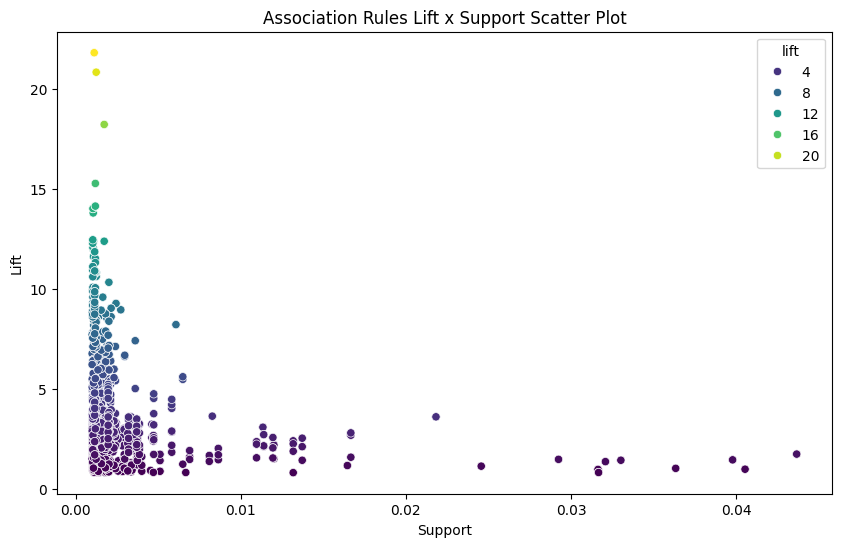

In [37]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rules, x='support', y='lift', hue='lift', palette='viridis')
plt.title('Association Rules Lift x Support Scatter Plot')
plt.xlabel('Support')
plt.ylabel('Lift')
plt.show()

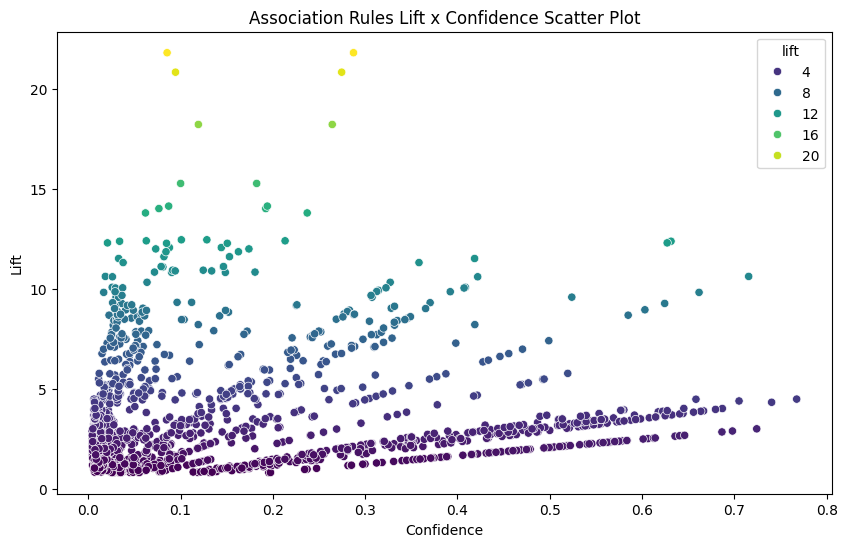

In [39]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rules, x='confidence', y='lift', hue='lift', palette='viridis')
plt.title('Association Rules Lift x Confidence Scatter Plot')
plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.show()

In [27]:
# Combine antecedent & consequent
rules['rule'] = rules['antecedents'].apply(lambda x: ', '.join(x)) + ' => ' + rules['consequents'].apply(lambda x: ', '.join(x))
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,rule
0,(Perfume),(Bow),0.089960,0.054645,0.004535,0.050411,0.922523,1.0,-0.000381,0.995542,-0.084488,0.032377,-0.004478,0.066701,Perfume => Bow
1,(Bow),(Perfume),0.054645,0.089960,0.004535,0.082990,0.922523,1.0,-0.000381,0.992399,-0.081590,0.032377,-0.007659,0.066701,Bow => Perfume
2,(Prescription Med),(Bow),0.014505,0.054645,0.001335,0.092037,1.684275,1.0,0.000542,1.041183,0.412253,0.019686,0.039554,0.058234,Prescription Med => Bow
3,(Bow),(Prescription Med),0.054645,0.014505,0.001335,0.024430,1.684275,1.0,0.000542,1.010174,0.429757,0.019686,0.010072,0.058234,Bow => Prescription Med
4,(Bow),(Shampoo),0.054645,0.033800,0.002590,0.047397,1.402273,1.0,0.000743,1.014273,0.303454,0.030167,0.014072,0.062012,Bow => Shampoo


In [30]:
# Sort by lift in descending order and select top 5
top_5_rules = rules.sort_values(by='lift', ascending=False).head(5)

# Display the top 5 rules
print(top_5_rules[['rule', 'antecedents', 'consequents', 'support', 'confidence', 'lift']])

                                              rule             antecedents  \
1168      Perfume, Shampoo => Magazine, Toothbrush      (Perfume, Shampoo)   
1173      Magazine, Toothbrush => Perfume, Shampoo  (Magazine, Toothbrush)   
692           Perfume, Bow => Magazine, Toothbrush          (Perfume, Bow)   
697           Magazine, Toothbrush => Perfume, Bow  (Magazine, Toothbrush)   
557   Prescription Med => Magazine, Wrapping Paper      (Prescription Med)   

                     consequents   support  confidence       lift  
1168      (Magazine, Toothbrush)  0.001125    0.287356  21.810727  
1173          (Perfume, Shampoo)  0.001125    0.085389  21.810727  
692       (Magazine, Toothbrush)  0.001245    0.274531  20.837300  
697               (Perfume, Bow)  0.001245    0.094497  20.837300  
557   (Magazine, Wrapping Paper)  0.001730    0.119269  18.222951  


<ipython-input-34-726493fee081>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='lift', y='rule', data=top_5_rules, palette='viridis')


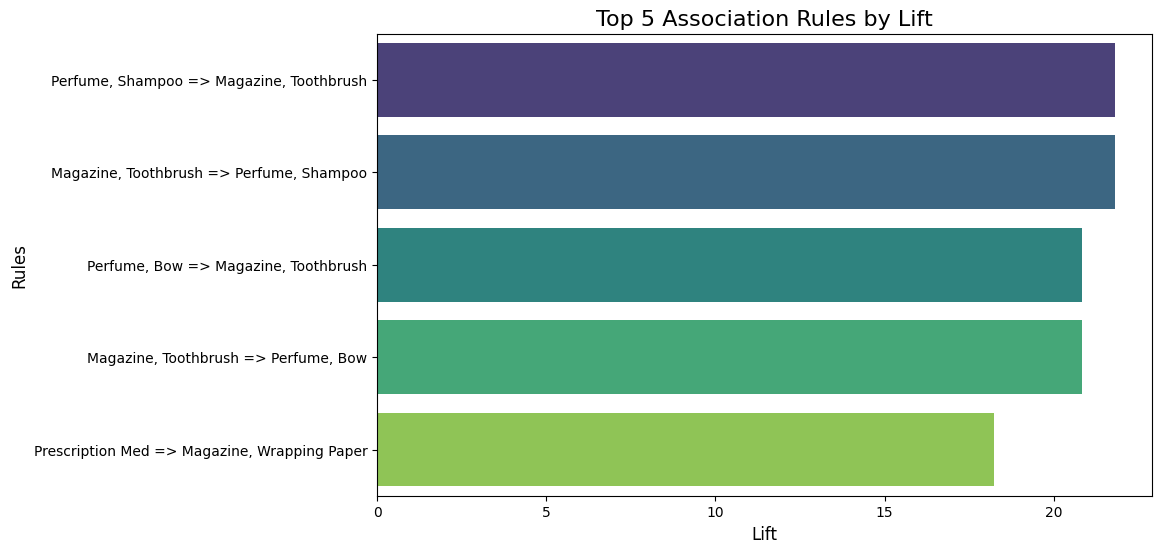

In [34]:
# Plot the top 5 rules by lift
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(x='lift', y='rule', data=top_5_rules, palette='viridis')

# Customize the plot
plt.title('Top 5 Association Rules by Lift', fontsize=16)
plt.xlabel('Lift', fontsize=12)
plt.ylabel('Rules', fontsize=12)
plt.show()

In [31]:
# Sort by lift in descending order and select bottom 5
bottom_5_rules = rules.sort_values(by='lift').head(5)

# Display the bottom 5 rules
print(bottom_5_rules[['rule', 'antecedents', 'consequents', 'support', 'confidence', 'lift']])

                                     rule                  antecedents  \
191  Shampoo => Candy Bar, Greeting Cards                    (Shampoo)   
186  Candy Bar, Greeting Cards => Shampoo  (Candy Bar, Greeting Cards)   
31                 Toothbrush => Magazine                 (Toothbrush)   
30                 Magazine => Toothbrush                   (Magazine)   
582          Soap => Magazine, Toothpaste                       (Soap)   

                     consequents   support  confidence      lift  
191  (Candy Bar, Greeting Cards)  0.001190    0.035207  0.806393  
186                    (Shampoo)  0.001190    0.027256  0.806393  
31                    (Magazine)  0.013175    0.195620  0.810675  
30                  (Toothbrush)  0.013175    0.054599  0.810675  
582       (Magazine, Toothpaste)  0.001110    0.025799  0.814747  


<ipython-input-35-fb870c7751ee>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='lift', y='rule', data=bottom_5_rules, palette='viridis')


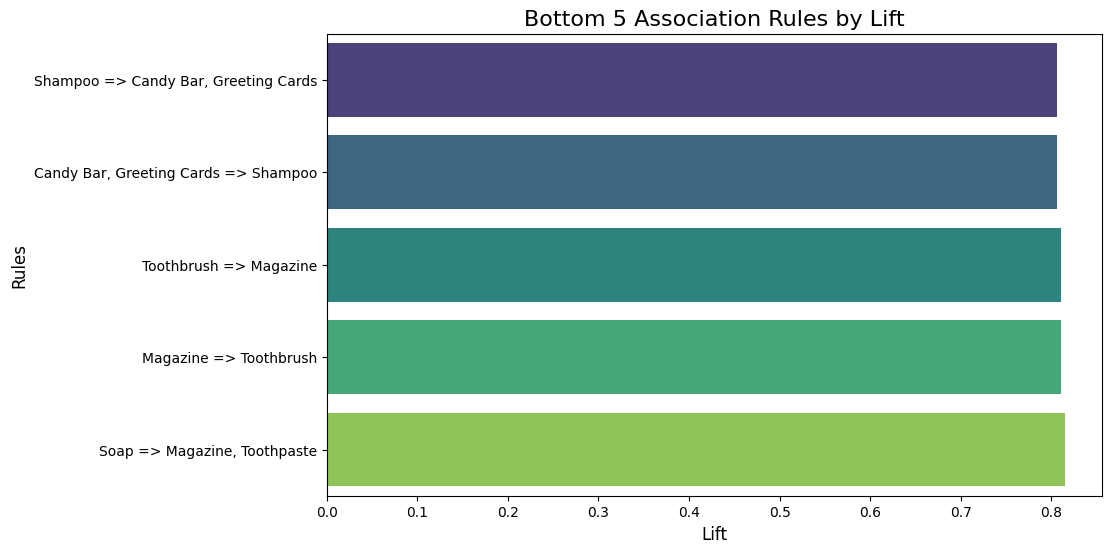

In [35]:
# Plot the top 5 rules by lift
plt.figure(figsize=(10, 6))
sns.barplot(x='lift', y='rule', data=bottom_5_rules, palette='viridis')

# Customize the plot
plt.title('Bottom 5 Association Rules by Lift', fontsize=16)
plt.xlabel('Lift', fontsize=12)
plt.ylabel('Rules', fontsize=12)
plt.show()